# Visualization in Depth With Bokeh

For details on bokeh, see http://bokeh.pydata.org/en/latest/docs/user_guide.html#userguide

The objectives of this lecture are:
- Describe how to create interactive visualizations using bokeh
 - Running example and visualization goals
 - How to approach a new system
 - Hover
 - Widgets
- Study bokeh as a system
 - Function specification - what it provides programmers
 - Design (which has client and server parts)

## How to Learn a New System

Steps
- Find an example close to what you want
- Create an environment that runs the example
- Abstract the key concepts of how it works
- Transform the example into what you want

## Running Example - Biological Data

In [1]:
from bokeh.plotting import figure, output_file, show, output_notebook
import random
import numpy as np
import pandas as pd
output_notebook()  # Use so see output in the Jupyter notebook

Loading BokehJS ...

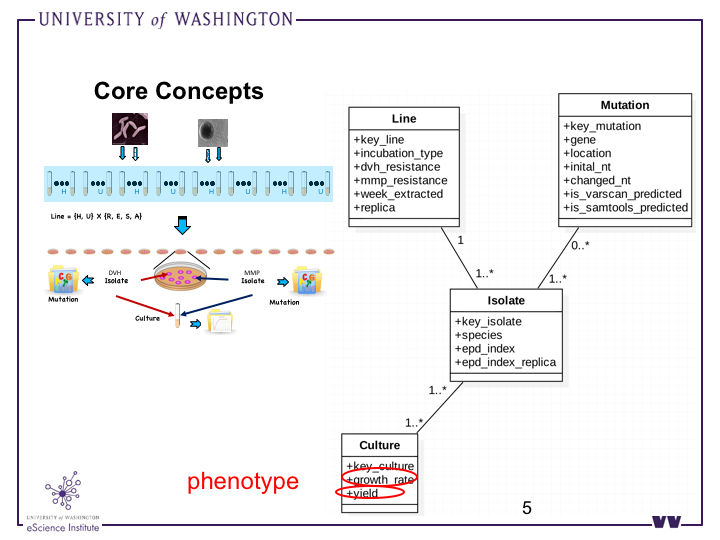

In [2]:
from IPython.display import Image
Image(filename='biological_data.png') 

In [3]:
df_bio = pd.read_csv("biological_data.csv")
df_bio.head()

,Unnamed: 0,culture,line,rate,yield
0,0,C0,HA,0.035581,0.531100
1,1,C1,HA,0.035072,0.528433
2,2,C2,HA,0.035883,0.534548
3,3,C217,HA,0.006110,0.025020
4,4,C218,HA,0.006510,0.024930


Desired visualization
- Scatterplot of rate vs. yield
- Hover shows the evolutionary "line"
- Widgets can specify color (and legend) for values of line

## Step 1: Find something close

In [4]:
plot = figure(plot_width=400, plot_height=400)
plot.circle(df_bio['rate'], df_bio['yield'])
plot.xaxis.axis_label = 'rate'
plot.yaxis.axis_label = 'yield'
show(plot)

### Step 1a: Distinguish "evolutionary lines" by color

Let's distinguish the lines with colors. First, how many lines are there?

In [5]:
# What are the possible colors
df_bio['line'].unique()

array(['HA', 'HR', 'UA', 'WT'], dtype=object)

In [6]:
# Generate a plot with a different color for each line
colors = {'HA': 'red', 'HR': 'green', 'UA': 'blue', 'WT': 'purple'}
plot = figure(plot_width=700, plot_height=800)
plot.title.text = 'Click on legend entries to hide the corresponding lines'
for line in list(colors.keys()):
    df = df_bio[df_bio.line == line]
    color = colors[line]
    plot.circle(df['rate'], df['yield'], color=color, legend=line)
plot.legend.location = "top_right"
show(plot)

What colors are possible to use? Check out bokeh.palettes

In [7]:
import bokeh.palettes as palettes
print palettes.__doc__
#palettes.magma(4)

 Provide a collection of palettes for color mapping.

Palettes are simple plain Python lists of (hex) RGB colors. This module
containts the following sets of palettes:

* All Brewer palettes
* Magma
* Inferno
* Plasma
* Viridis

Every pre-built palette is available as a module attributes, e.g.
``bokeh.palettes.YlGn3`` or ``bokeh.palettes.Viridis256``. The name of every
all pre-built palettes can be found in the ``__palettes__`` module attribute.

There are functions :func:`~bokeh.palettes.magma`,
:func:`~bokeh.palettes.inferno`, :func:`~bokeh.palettes.plasma`,
:func:`~bokeh.palettes.viridis` that can generate lists of colors of arbitrary
size from those palettes.

The Brewer palettes are also collected and grouped by name in a
``brewer`` dictionary, e.g.: ``brewer['Spectral'][6]``

Finally, all "small" palettes (i.e. excluding the 256 color ones) are
collected and grouped similarly in a ``small_palettes`` attribute.
The complete contents of ``small_palettes`` is show below.

----

.. b

Question: How do I handle colors for the plot for an arbitrary number of evolutionary lines? (Hint: construct the colors dictionary using the values of 'line' and a palette.)

In [8]:
# Generate the colors dictionary
lines = df_bio['line'].unique().tolist()
my_palette = palettes.magma(len(lines))
colors = {}
for idx in range(len(lines)):
  colors[lines[idx]] = my_palette[idx] 
colors

{'HA': '#000003', 'HR': '#711F81', 'UA': '#F0605D', 'WT': '#FBFCBF'}

In [9]:
# Plot with the generated palette
plot = figure(plot_width=700, plot_height=800)
plot.title.text = 'Click on legend entries to hide the corresponding lines'
for line in list(colors.keys()):
    df = df_bio[df_bio.line == line]
    color = colors[line]
    plot.circle(df['rate'], df['yield'], color=color, legend=line)
plot.legend.location = "top_right"
show(plot)

### Bokeh tools

Tools can be specified and positioned when the Figure is created. The interaction workflow is (a) select a tool (identified by vertical blue line), (b) perform gesture for tool.

In [10]:
TOOLS = 'box_zoom,box_select,crosshair,resize,reset'
plot = figure(plot_width=200, plot_height=200, title=None, tools=TOOLS)
plot.scatter(range(10), range(10))
show(plot)

In [11]:
from bokeh.models import HoverTool, BoxSelectTool
TOOLS = [HoverTool(), BoxSelectTool()]
plot = figure(plot_width=200, plot_height=200, title=None, tools=TOOLS)
show(plot)

### Some Bokeh Concepts (Classes)

**Figure**
- Created using the figure()
- Controls the size of the plot
- Allows other elements to be added
- Has properties for title, x-axis label, y-axis label

**Glyph**
- Mark that's added to the plot - circle, line, polygon
- Created using Figure methods plot.circle(df['rate'], df['yield'], color=color, legend=line)

**Tool**
- Provides user interactions with the graph using gestures
- Created using a separate constructor (


### Adding a Hover Tool

Based on our knowledge of Bokeh concepts, is a Tool associated with Figure or Glyph?

Which classes will be involved in hovering:
- Plot & Tool only
- Glyph only
- Tool and Glyph

Start with some examples. First, simple hovering.

In [12]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool, BoxSelectTool

output_file("toolbar.html")
TOOLS = [BoxSelectTool(), HoverTool()]

p = figure(plot_width=400, plot_height=400, title=None, tools=TOOLS)

p.circle([1, 2, 3, 4, 5], [2, 5, 8, 2, 7], size=10)

show(p)

Now add ad-hoc data

In [13]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

output_file("toolbar.html")

source = ColumnDataSource(
        data=dict(
            x=[1, 2, 3, 4, 5],
            y=[2, 5, 8, 2, 7],
            desc=['A', 'b', 'C', 'd', 'E'],
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=20, source=source)

show(p)

## Bokeh Widgets

In [15]:
from bokeh.io import output_file, show
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Button

output_file("button.html")

button = Button(label="Foo", button_type="success")


show(widgetbox(button))

In [19]:
    from bokeh.io import output_file, show
    from bokeh.layouts import widgetbox
    from bokeh.models.widgets import Dropdown

    output_file("dropdown.html")


    menu = [("Item 1", "item_1"), ("Item 2", "item_2"), None, ("Item 3", "item_3")]
    dropdown = Dropdown(label="Dropdown button", button_type="warning", menu=menu)

    def function_to_call(attr, old, new):
        import pdb; pdb.set_trace()
        print dropdown.value

    dropdown.on_change('value', function_to_call)
    dropdown.on_click(function_to_call)
    show(widgetbox(dropdown))

## Bokeh Architecture

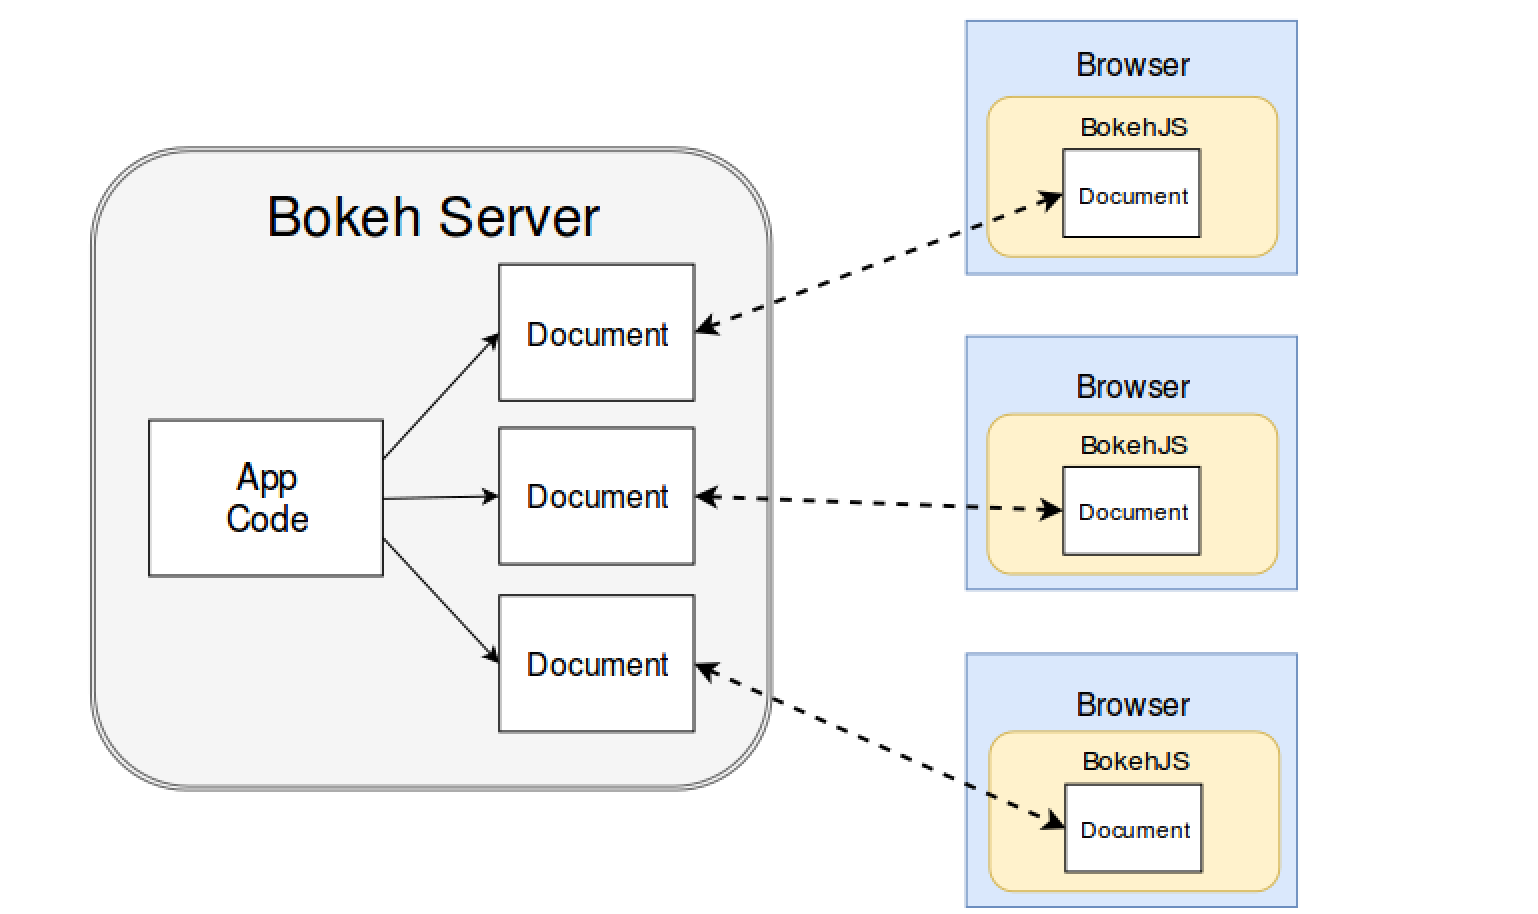

In [20]:
Image(filename='BokehArchitecture.png') 